# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [209]:
df = pd.read_csv('Frozen_Dessert_Production.csv',parse_dates=['DATE'],index_col='DATE')

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [210]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [211]:
df.isnull().sum()

IPN31152N    0
dtype: int64

In [212]:
df.rename(columns={'IPN31152N':'Production'},inplace=True)

In [213]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [215]:
df["year"] = df.index.year
df['month'] = df.index.month 
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour 
df["date"] = df.index.date

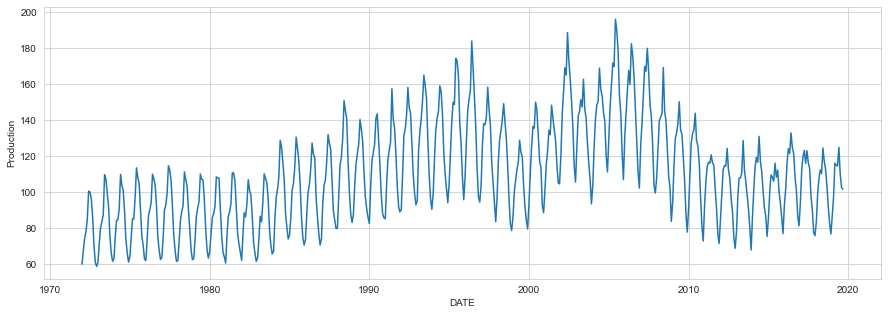

In [216]:
plt.figure(figsize=(15,5))
sns.lineplot(df.index, "Production", data=df);

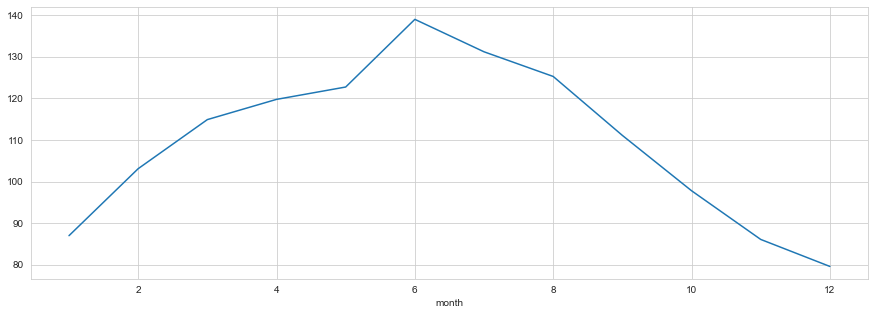

In [217]:
#Plot bike share over months
month_cnt = df.groupby("month")["Production"].mean()
plt.figure(figsize=(15,5))
sns.lineplot(month_cnt.index, month_cnt.values);

In [218]:
df.drop(columns=['date'],inplace=True)

In [219]:
df.drop(columns=['hour'],inplace=True)

In [220]:
df

,Production,year,month,day,dayofweek
DATE,,,,,
1972-01-01,59.962,1972,1,1,5
1972-02-01,67.061,1972,2,1,1
1972-03-01,74.235,1972,3,1,2
1972-04-01,78.112,1972,4,1,5
1972-05-01,84.764,1972,5,1,0
...,...,...,...,...,...
2019-05-01,114.561,2019,5,1,2
2019-06-01,124.960,2019,6,1,5
2019-07-01,110.263,2019,7,1,0


In [221]:
df.drop(columns=['year','month','day','dayofweek'],inplace=True)

## Preprocessing of Data

### Train Test Split

In [222]:
test_size = 24

In [223]:
test_ind = len(df)- test_size

In [224]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [225]:
from sklearn.preprocessing import MinMaxScaler

In [226]:
scaler = MinMaxScaler()

In [227]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [228]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [229]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [230]:
X, y = generator[0]

## Modelling & Model Performance

### Import related libraries

In [231]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [232]:
n_features = train_scaled.shape[1]

### Creating Model

### with "tanh" activation function

In [233]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [234]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 12, 64)            16896     
                                                                 
 lstm_12 (LSTM)              (None, 12, 32)            12416     
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [235]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [236]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 8s 10ms/step - loss: 0.0321 - val_loss: 0.0065
Epoch 2/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 3/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 5/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/20
537/537 [==============================] - 5s 8ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 8/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 9/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0066 - val_loss: 0.0018


#### Evaluate on Test Data

In [237]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [238]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [240]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [241]:
predictions = scaler.inverse_transform(predictions_scaled)

In [244]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,97.970
2017-11-01,77.438,83.241
2017-12-01,75.812,84.778
2018-01-01,83.434,98.535
2018-02-01,99.490,110.834
2018-03-01,107.315,116.435
2018-04-01,112.431,115.818
2018-05-01,110.354,116.160
2018-06-01,124.584,117.987


<AxesSubplot:xlabel='DATE'>

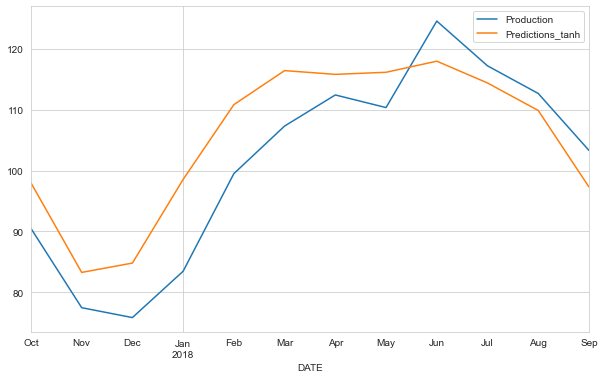

In [245]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [246]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.7346903510744769 
mae: 7.104314353054758 
mse: 62.56550344343099 
rmse: 7.909835867034852


### with "relu" activation function

In [247]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [248]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [249]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 8s 10ms/step - loss: 0.0352 - val_loss: 0.0089
Epoch 2/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0179 - val_loss: 0.0053
Epoch 3/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0124 - val_loss: 0.0015
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0091 - val_loss: 0.0032
Epoch 5/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 7/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 8/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 9/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 10/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0069 - val_loss: 0.0

<AxesSubplot:>

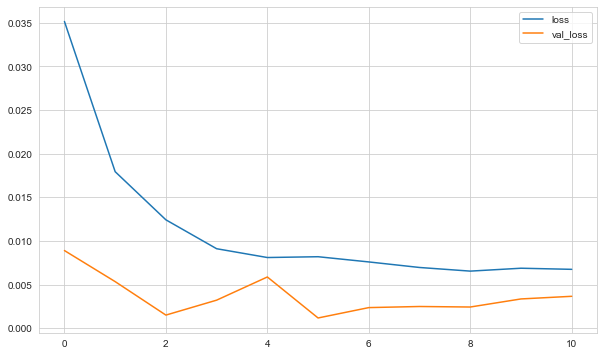

In [250]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [251]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [252]:
predictions = scaler.inverse_transform(predictions_scaled)

In [253]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,97.970,97.294
2017-11-01,77.438,83.241,84.960
2017-12-01,75.812,84.778,88.424
2018-01-01,83.434,98.535,102.864
2018-02-01,99.490,110.834,114.393
2018-03-01,107.315,116.435,119.549
2018-04-01,112.431,115.818,118.214
2018-05-01,110.354,116.160,119.009
2018-06-01,124.584,117.987,119.762


<AxesSubplot:xlabel='DATE'>

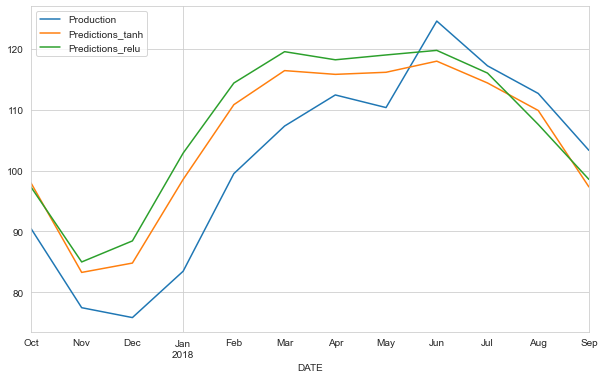

In [254]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [255]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5783341355275835 
mae: 8.65374803744542 
mse: 99.43753347256542 
rmse: 9.971837015944725


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [256]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [257]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [258]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 8s 9ms/step - loss: 0.0308
Epoch 2/10
561/561 [==============================] - 6s 10ms/step - loss: 0.0113
Epoch 3/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0092
Epoch 4/10
561/561 [==============================] - 5s 8ms/step - loss: 0.0075
Epoch 5/10
561/561 [==============================] - 5s 8ms/step - loss: 0.0072
Epoch 6/10
561/561 [==============================] - 5s 8ms/step - loss: 0.0071
Epoch 7/10
561/561 [==============================] - 6s 10ms/step - loss: 0.0071
Epoch 8/10
561/561 [==============================] - 6s 10ms/step - loss: 0.0071
Epoch 9/10
561/561 [==============================] - 5s 10ms/step - loss: 0.0068
Epoch 10/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0071


In [259]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [260]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[100.12616178],
       [ 86.45323533],
       [ 84.11890812],
       [ 96.50501996],
       [108.50654537],
       [121.27316181],
       [120.72994504],
       [122.70730586],
       [128.3549996 ],
       [118.29134033],
       [112.29187062],
       [111.2861559 ]])

In [261]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [262]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,100.126
2019-11-01,86.453
2019-12-01,84.119
2020-01-01,96.505
2020-02-01,108.507
2020-03-01,121.273
2020-04-01,120.730
2020-05-01,122.707
2020-06-01,128.355
2020-07-01,118.291


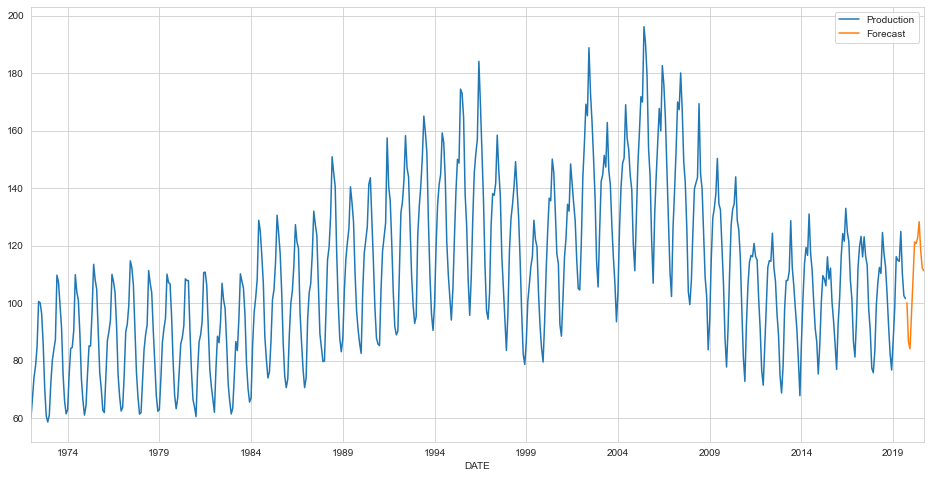

In [263]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

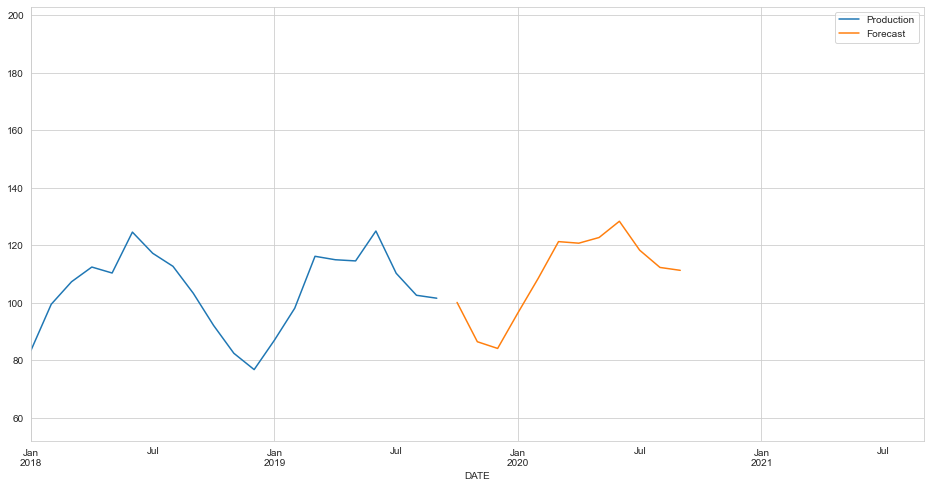

In [264]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')